In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Hyperparameters
num_epochs = 100
IMAGE_PATH = "/home/sam/Dropbox/datasets/foveaNET/_IMAGES_224"
LABEL_PATH = "/home/sam/Dropbox/datasets/foveaNET/_LABELS_224"
BATCH_SIZE = 64
RESIZE_DIM = 224
LEARNING_RATE = 0.0001

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform  # Use a single transform for spatial adjustments
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        # Apply spatial transformations to both image and label
        if self.transform:
            seed = torch.random.initial_seed()
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)  # Ensure label gets the same transformations
            label = self.transform(label)

        # Apply color transformations only to the image
        color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        image = color_jitter(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((RESIZE_DIM, RESIZE_DIM)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load dataset with combined transformations
full_dataset = CustomDataset(IMAGE_PATH, LABEL_PATH, transform=transform)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the pretrained MobileNetV2 model
mobilenet_v2_model = mobilenet_v2(pretrained=True)

# Create a new Deeplabv3 model with a modified MobileNetV2 backbone
class DeepLabV3MobileNetV2(nn.Module):
    def __init__(self):
        super(DeepLabV3MobileNetV2, self).__init__()
        self.backbone = nn.Sequential(*list(mobilenet_v2_model.features.children()))
        self.classifier = DeepLabHead(1280, 2)

    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.backbone(x)
        x = self.classifier(x)
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return {'out': x}

# Instantiate the model
model = DeepLabV3MobileNetV2()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

/home/sam/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sam/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).squeeze(1)  # Assuming the channel dimension is at dim=1

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, labels.long())  # Ensure labels are of the correct dtype
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).squeeze(1)

            outputs = model(images)['out']
            loss = criterion(outputs, labels.long())

            val_running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_running_loss/len(val_loader)}")

/home/sam/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100, Training Loss: 0.46837836131453514
Epoch 1/100, Validation Loss: 0.5870093405246735
Epoch 2/100, Training Loss: 0.2637492213398218
Epoch 2/100, Validation Loss: 0.3778388500213623
Epoch 3/100, Training Loss: 0.17538876086473465
Epoch 3/100, Validation Loss: 0.22719666361808777
Epoch 4/100, Training Loss: 0.13577851001173258
Epoch 4/100, Validation Loss: 0.14846289530396461
Epoch 5/100, Training Loss: 0.11318998550996184
Epoch 5/100, Validation Loss: 0.13470139354467392
Epoch 6/100, Training Loss: 0.09752451675012708
Epoch 6/100, Validation Loss: 0.12152480147778988
Epoch 7/100, Training Loss: 0.08823676314204931
Epoch 7/100, Validation Loss: 0.11520698480308056
Epoch 8/100, Training Loss: 0.08132850425317883
Epoch 8/100, Validation Loss: 0.10352198965847492
Epoch 9/100, Training Loss: 0.07675370387732983
Epoch 9/100, Validation Loss: 0.09742363356053829
Epoch 10/100, Training Loss: 0.07413262082263827
Epoch 10/100, Validation Loss: 0.09088972583413124
Epoch 11/100, Trainin

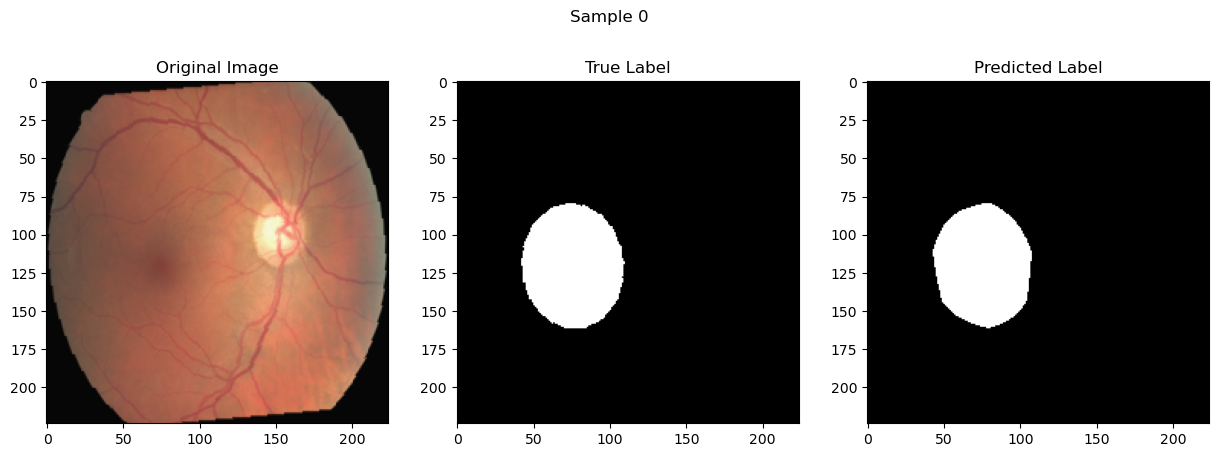

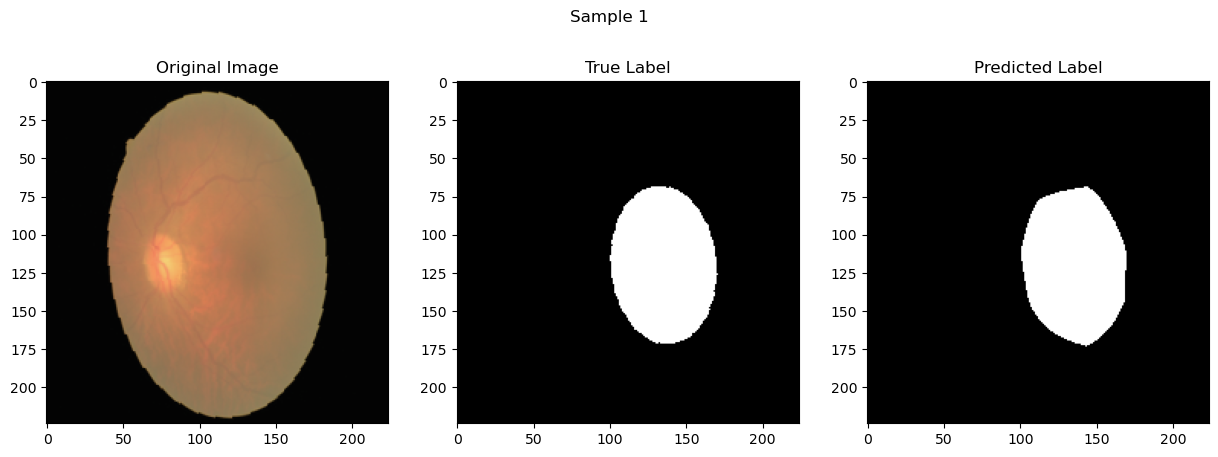

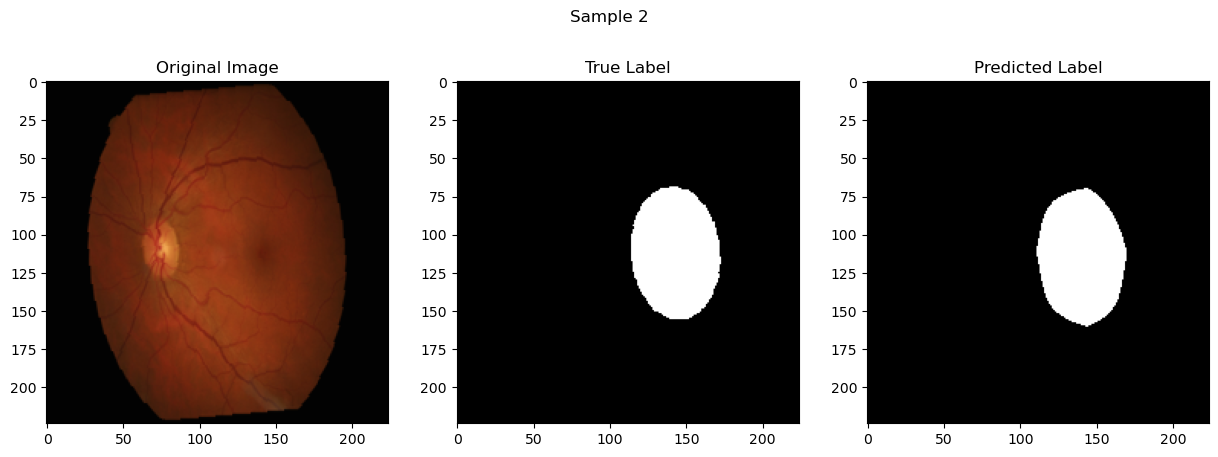

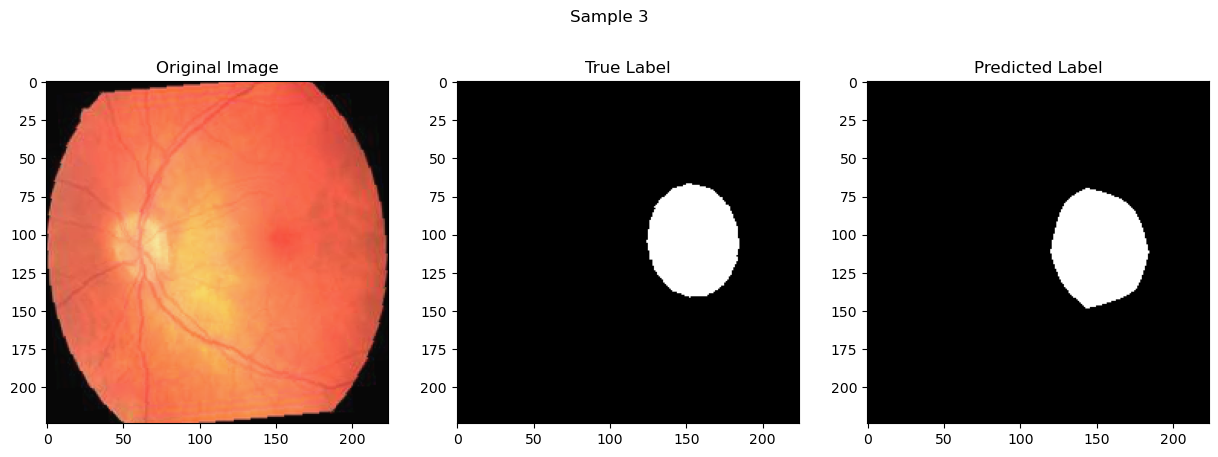

Test Loss: 0.053160701878368855
Mean IoU: 0.9412934023588015


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

num_samples_to_display = 5

def calculate_iou(label, prediction, num_classes=2):
    """Calculate mean Intersection over Union (IoU) for all classes."""
    iou_list = []
    for cls in range(num_classes):
        label_cls = label == cls
        prediction_cls = prediction == cls
        intersection = (label_cls & prediction_cls).sum()
        union = (label_cls | prediction_cls).sum()
        if union == 0:
            iou = float('nan')  # Avoid division by zero
        else:
            iou = intersection / union
        iou_list.append(iou)
    mean_iou = np.nanmean(iou_list)  # Compute mean IoU, ignoring NaN values
    return mean_iou

def visualize_image_with_labels(image, label, prediction, index):
    """Visualize an image with its true and predicted labels."""
    image = image.cpu().numpy().transpose((1, 2, 0))
    label = label.cpu().numpy()
    prediction = prediction.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('True Label')
    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title('Predicted Label')
    plt.suptitle(f'Sample {index}')
    plt.show()

# Testing phase with visualization and IoU calculation
model.eval()
test_running_loss = 0.0
total_iou = 0.0
num_samples = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device).squeeze(1)  # Assuming labels have a channel dimension

        outputs = model(images)['out']
        loss = criterion(outputs, labels.long())
        test_running_loss += loss.item()

        # Convert outputs to predicted labels
        _, preds = torch.max(outputs, 1)

        # Calculate IoU for each image and accumulate
        iou = calculate_iou(labels[0].cpu().numpy(), preds[0].cpu().numpy())
        total_iou += iou
        num_samples += 1

        if i < num_samples_to_display:
            visualize_image_with_labels(images[0], labels[0], preds[0], i)

mean_iou = total_iou / num_samples
print(f"Test Loss: {test_running_loss/len(test_loader)}")
print(f"Mean IoU: {mean_iou}")

In [5]:
# Save model
torch.save(model, 'model_fovea.pth')

# Test Loss: 0.06756701426846641
# Mean IoU: 0.9098113908334773